## The Battle of Neighborhoods - Codes

## Data

The most important data required to answer the problem statement includes the **locations and types of venues** around the Toronto city.

First, the **locations of travel accommodations** such as hotels, hostels and motels in the region will be extracted to estimate the flow of travellers and potential amount of customers that would frequent the laundromat as they are the primary target market. Next, the **locations of all existing laundromats or laundry services** will need to be obtained. This is to reduce the competition by setting up the laundromat a certain distance away from other existing laundromats. 

An ideal location for the laundromat would be at the centre of a cluster of hotels and hostels as mentioned. A clustering algorithm can be performed on the locations of travel accomodations and laundromats separately to find the concentration of both types of the establishments. The ideal location can be inferred by comparing both clustering results

## 1.) Create *pandas* datafrome of Neighborhoods in Toronto

### Downloading Libraries

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


### Extracting the html file from the URL

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url).text

print('Data downloaded!')

Data downloaded!


### Using BeautfilSoup for table row containing postcodes

In [3]:
soup = BeautifulSoup(r,'lxml')
btable = soup.find('table')
tab_rows = btable.find_all('tr')

### Transform the data into a pandas dataframe

In [4]:
# define the dataframe columns
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 

# instantiate the dataframe
postcodes = pd.DataFrame(columns=column_names)

for n in range(1,len(tab_rows)):
    row_t = tab_rows[n].text.split('\n')
    if row_t[2] != 'Not assigned':  # Skip rows with 'Not assigned' Boroughs
        if row_t[3] == 'Not assigned':  # Copying Borough name to 'Not assigned' Neighborhoods
            row_t[3] = row_t[2]
        if row_t[1] in postcodes.loc[:,'PostalCode'].unique():  # Appending the Neighborhood names to duplicate PostalCode areas
            postcodes.loc[tag,'Neighborhood'] = postcodes.loc[tag,'Neighborhood'] + ', ' + row_t[3]
        else: 
            postcodes.loc[n,:] = row_t[1:4]
            tag = n

postcodes.reset_index(drop=True,inplace=True)
postcodes.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


### Print the number of rows of the dataframe

In [5]:
print('The size of the dataframe:', postcodes.shape)

The size of the dataframe: (103, 3)


### Download csv file with geographical coordinates of each postal code

In [6]:
import csv

!wget -q -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data
print('Data downloaded!')

# read csv file
coord = pd.read_csv('Geospatial_Coordinates.csv')
coord.head()

Data downloaded!


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Match Postal Codes to the coordinate values to populate the dataframe

In [7]:
for i,n in enumerate(postcodes['PostalCode']):
    res = coord[coord['Postal Code']==n]
    postcodes.loc[i,'Latitude'] = res.Latitude.values
    postcodes.loc[i,'Longitude'] = res.Longitude.values

postcodes.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


### Neighborhoods in the burough of Central Toronto

In [8]:
central = postcodes[postcodes['Borough']=='Central Toronto'].reset_index(drop=True)
central

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
5,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
6,M4S,Central Toronto,Davisville,43.704324,-79.388790
7,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
8,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


## 2.) Search for hotels, hostels and motels in Central Toronto

### Downloading required Libraries

In [9]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import numpy as np
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.5           |   py36h1ba5d50_0         643 KB
    conda-4.6.3                |           py36_0         872 KB  conda-forge
    openssl-1.1.1a             |    h14c3975_1000         4.0 MB  conda-forge
    libarchive-3.3.3           |       h5d8350f_5         1.5 MB
    grpcio-1.16.1              |   py36hf8bcb03_1         1.1 MB
    libssh2-1.8.0              |                1         239 KB  conda-forge
    python-3.6.8               |       h0371630_0        34.4 MB
    ------------------------------------------------------------
                                           Total:        42.6 MB

The following packages will be UPDATED:

    conda:        4.5.12-py36_1000         conda

### Define Foursquare credentials and version

In [11]:
CLIENT_ID = 'NHZOV5ISEMB3VWNLRUAQHL2DS4UIEWBROQXV0JYRWKHFV5XS' # your Foursquare ID
CLIENT_SECRET = '0LU1L02OT50RRR1GCA2KX01H0ENR2E2ZL132QX1GR5RFMKQF' # your Foursquare Secret
VERSION = '20181111' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NHZOV5ISEMB3VWNLRUAQHL2DS4UIEWBROQXV0JYRWKHFV5XS
CLIENT_SECRET:0LU1L02OT50RRR1GCA2KX01H0ENR2E2ZL132QX1GR5RFMKQF


### Define getNearbyHotelVenues function from FourSquare

In [12]:
def getNearbyHotelVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Hostel Hotel',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Select a subset to explore the hotels in the neighborhoods 

In [14]:
hotel_venues = getNearbyHotelVenues(central['Neighborhood'],central["Latitude"],central['Longitude'],2000)
hotel_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
1,Lawrence Park,43.728020,-79.388790,Hotel Wibke,43.707730,-79.395858,Speakeasy
2,Lawrence Park,43.728020,-79.388790,Skyline Hotels & Resorts,43.707578,-79.395640,Office
3,Roselawn,43.711695,-79.416936,Hotel Gelato,43.703478,-79.414311,Café
4,Roselawn,43.711695,-79.416936,Hotel Wibke,43.707730,-79.395858,Speakeasy


## 3.) Search for laundromats in Central Toronto

### Define getNearbyLaundryVenues function from FourSquare

In [16]:
def getNearbyLaundryVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            'Laundromat Laundry',
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Select a subset to explore the laundromats in the neighborhoods 

In [17]:
laundry_venues = getNearbyLaundryVenues(central['Neighborhood'],central["Latitude"],central['Longitude'],2000)
laundry_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Maytag Laundry Linens And Gifts,43.730241,-79.403576,Laundry Service
1,Roselawn,43.711695,-79.416936,Bathurst Street Coin Laundry,43.723356,-79.430118,Laundry Service
2,Roselawn,43.711695,-79.416936,Royal Forest Coin Laundry,43.701115,-79.425177,Laundry Service
3,Roselawn,43.711695,-79.416936,Maytag Coin Laundry,43.728040,-79.432170,Laundry Service
4,Roselawn,43.711695,-79.416936,Coin Laundry,43.724148,-79.430481,Laundry Service


## 4.) Perform hierarchical clustering on laundromat and hotel locations in Central Toronto

### Generate Folium map (Toronto city hall as the centre of Toronto) to show the location of laundromats and hotels 

In [20]:
# Assuming Toronto coordinates as 43.653170, -79.383541
latitude = 43.653170
longitude = -79.383541

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(laundry_venues['Venue Latitude'], laundry_venues['Venue Longitude'], laundry_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Coordinates of laundromats and hotels

In [21]:
laundry_feature = laundry_venues[['Venue Latitude','Venue Longitude']]
hotel_feature = hotel_venues[['Venue Latitude','Venue Longitude']]

### Hierarchical clustering to group nearby laundromats and hotels 

In [25]:
from sklearn.preprocessing import MinMaxScaler
laundry_data = laundry_feature.values #returns a numpy array
hotel_data = hotel_feature.values
min_max_scaler = MinMaxScaler()
laundry_mtx = min_max_scaler.fit_transform(laundry_data)
hotel_mtx = min_max_scaler.fit_transform(hotel_data)
laundry_mtx [0:5]

array([[1.        , 0.3904177 ],
       [0.91227002, 0.02986149],
       [0.6288908 , 0.09697779],
       [0.97195562, 0.00198117],
       [0.9223651 , 0.02492547]])

In [26]:
import scipy
laundry_leng = laundry_mtx.shape[0]
laundry_D = scipy.zeros([laundry_leng,laundry_leng])
for i in range(laundry_leng):
    for j in range(laundry_leng):
        laundry_D[i,j] = scipy.spatial.distance.euclidean(laundry_mtx[i], laundry_mtx[j])
        
print(laundry_D)

[[0.         0.3710759  0.47310571 ... 0.77721087 0.8358833  0.37579332]
 [0.3710759  0.         0.29121879 ... 0.71454066 0.96253584 0.60775833]
 [0.47310571 0.29121879 0.         ... 0.42528853 0.7289435  0.49889405]
 ...
 [0.77721087 0.71454066 0.42528853 ... 0.         0.44788785 0.56121957]
 [0.8358833  0.96253584 0.7289435  ... 0.44788785 0.         0.47154443]
 [0.37579332 0.60775833 0.49889405 ... 0.56121957 0.47154443 0.        ]]


### Import Library

In [27]:
# Import libraries
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
import pylab
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


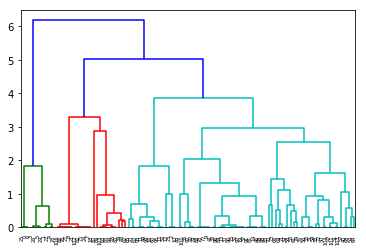

In [28]:
# Perform clustering
laundry_Z = hierarchy.linkage(laundry_D, 'complete')
max_d = 3
laundry_clusters = fcluster(laundry_Z, max_d, criterion='distance')
laundry_dend = hierarchy.dendrogram(laundry_Z)

In [29]:
hotel_leng = hotel_mtx.shape[0]
hotel_D = scipy.zeros([hotel_leng,hotel_leng])
for i in range(hotel_leng):
    for j in range(hotel_leng):
        hotel_D[i,j] = scipy.spatial.distance.euclidean(hotel_mtx[i], hotel_mtx[j])
        
print(hotel_D)

[[0.         0.11496622 0.11058236 ... 0.66262782 0.6976536  0.70322326]
 [0.11496622 0.         0.00561036 ... 0.64194521 0.66927393 0.71347955]
 [0.11058236 0.00561036 0.         ... 0.6389582  0.66664415 0.70935534]
 ...
 [0.66262782 0.64194521 0.6389582  ... 0.         0.05542548 0.19156599]
 [0.6976536  0.66927393 0.66664415 ... 0.05542548 0.         0.23590316]
 [0.70322326 0.71347955 0.70935534 ... 0.19156599 0.23590316 0.        ]]


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


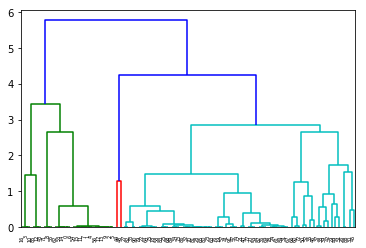

In [30]:
# Perform clustering
hotel_Z = hierarchy.linkage(hotel_D, 'complete')
max_d = 3
hotel_clusters = fcluster(hotel_Z, max_d, criterion='distance')
hotel_dend = hierarchy.dendrogram(hotel_Z)

## 5.) Find suitable location for a new laundromat

### Assign cluster numbers to laundromats and hotels 

In [31]:
laundry_venues['cluster_'] = laundry_clusters
hotel_venues['cluster_'] = hotel_clusters

### Generate Folium map to illustrate the clusters for laundromats (reds) and hotels (blues)

In [32]:
# Assuming Toronto coordinates as 43.653170, -79.383541
latitude = 43.653170
longitude = -79.383541

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the laundromat clusters
laundry_kclusters = laundry_clusters.max()
x = np.arange(laundry_kclusters)
ys = [i+x+(i*x)**2 for i in range(laundry_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(laundry_venues['Venue Latitude'], laundry_venues['Venue Longitude'], laundry_venues['Venue'], laundry_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hotel_venues['Venue Latitude'], hotel_venues['Venue Longitude'], hotel_venues['Venue'], hotel_venues['cluster_']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Extracting coordinate of cluster centres for visualisation 

In [34]:
laundry_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
laundry_count = pd.DataFrame(columns=['Number of Venues'])
hotel_mean = pd.DataFrame(columns=['Venue Latitude','Venue Longitude'])
hotel_count = pd.DataFrame(columns=['Number of Venues'])

for i in range(1,laundry_kclusters+1):
    laundry_mean.loc[i-1,:]=laundry_venues[laundry_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    laundry_count.loc[i-1] = laundry_venues[laundry_venues['cluster_']==i]['cluster_'].count()

for i in range(1,hotel_kclusters+1):
    hotel_mean.loc[i-1,:]=hotel_venues[hotel_venues['cluster_']==i][['Venue Latitude','Venue Longitude']].mean()
    hotel_count.loc[i-1] = hotel_venues[hotel_venues['cluster_']==i]['cluster_'].count()
    
laundry_mean = pd.concat([laundry_mean, laundry_count], axis=1, sort=False)
hotel_mean = pd.concat([hotel_mean, hotel_count], axis=1, sort=False)
print('Laundromat clusters: \n',laundry_mean)
print('Hotel clusters: \n',hotel_mean)

Laundromat clusters: 
   Venue Latitude Venue Longitude Number of Venues
0        43.7271        -79.4236               11
1         43.705        -79.3884               12
2        43.6688        -79.3786               11
3        43.6872        -79.4246               16
4        43.6702        -79.4063               57
Hotel clusters: 
   Venue Latitude Venue Longitude Number of Venues
0        43.6959        -79.4155                6
1        43.7075        -79.3911               20
2         43.656        -79.4106                2
3         43.668        -79.3916               64


### Generate Folium map showing laundromats and hotel clusters with larger circles representing higher concentration of venues 

In [35]:
# Assuming Toronto coordinates as 43.653170, -79.383541
latitude = 43.653170
longitude = -79.383541

# create map
map_center_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the laundromat clusters
laundry_kclusters = laundry_clusters.max()
x = np.arange(laundry_kclusters)
ys = [i+x+(i*x)**2 for i in range(laundry_kclusters)]
colors_array = cm.rainbow(np.linspace(0.8, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_laundry = laundry_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(laundry_mean['Venue Latitude'], laundry_mean['Venue Longitude'], laundry_mean['Number of Venues'],laundry_mean.index):
    label = folium.Popup(' Laundromat Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_laundry*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
    
# set color scheme for the hotel clusters
hotel_kclusters = hotel_clusters.max()
x = np.arange(hotel_kclusters)
ys = [i+x+(i*x)**2 for i in range(hotel_kclusters)]
colors_array = cm.rainbow(np.linspace(0.1, 0.3, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
scale_hotel = hotel_mean['Number of Venues'].max()
for lat, lon, clustsize, clustnum in zip(hotel_mean['Venue Latitude'], hotel_mean['Venue Longitude'], hotel_mean['Number of Venues'], hotel_mean.index):
    label = folium.Popup(' Hotel Cluster ' + str(clustnum+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=clustsize/scale_hotel*30,
        popup=label,
        color=rainbow[clustnum],
        fill=True,
        fill_color=rainbow[clustnum],
        fill_opacity=0.7).add_to(map_center_clusters)
       
map_center_clusters